In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import dill as pickle

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<ipython-input-1-06da3225ef62>:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Dataset

## Mobility

In [2]:
mobility_data = pd.read_csv(
    "./Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"],
    dayfirst=True
)
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & 
    (~mobility_data["sub_region_1"].isnull()) &
    (mobility_data["sub_region_2"].isnull())
]
mobility_data_us_temp = mobility_data_us.iloc[:,7:] # keep only relevant columns
mobility_data_us_temp["state"] = mobility_data_us["sub_region_1"]
mobility_data_us_temp.iloc[:,1:-1] = mobility_data_us_temp.iloc[:,1:-1].apply(lambda x: x/100 + 1)
mobility_data_us =  mobility_data_us_temp.reset_index(drop=True)
mobility_data_us = pd.DataFrame({
    "state": mobility_data_us["state"],
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

processed_dfs = []

for state in mobility_data_us["state"].unique():
    d = mobility_data_us[mobility_data_us["state"] == state].copy()
    
    d["HOME"] = d["HOME"].rolling(7).median()
    d["WORK"] = d["WORK"].rolling(7).median()
    d["RECREATIONAL"] = d["RECREATIONAL"].rolling(7).median()
    d["OTHER"] = d["OTHER"].rolling(7).median()

    processed_dfs.append(d)
    
mobility_data_us = pd.concat(processed_dfs)

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cases

In [3]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "./Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"],
    dayfirst=False
)
ms_us_covid = ms_covid[
    (ms_covid["Country_Region"]=="United States") & 
    (~ms_covid["AdminRegion1"].isnull()) &
    (ms_covid["AdminRegion2"].isnull())
]
ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
ms_us_covid.reset_index(drop=True, inplace=True)
population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls",
)
STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))

processed_dfs = []

for state in ms_us_covid["state"].unique():
    d = ms_us_covid[ms_us_covid["state"] == state]
    d = d.fillna(method='ffill').fillna(0)
    d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

    d["S"] = int(STATE_POPULATION[state]) - d["I"]

    d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
    d["I"] = np.log(d["I"].rolling(7).median()+1)
    d["S"] = np.log(d["S"].rolling(7).median()+1)

    d.dropna(inplace=True)
    processed_dfs.append(d)
    
ms_us_covid = pd.concat(processed_dfs)
ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

## Merge

In [4]:
final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"]
)
final_data.dropna(inplace=True)
final_data.set_index("state", inplace=True)

In [5]:
final_data.to_pickle("tmp/final_data.pkl")

# Model

In [6]:
from model import COVIDGPModel

In [7]:
def run_for_state(name, data):
    data = data.copy()
    data.reset_index(inplace=True, drop=True)
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]

    model_params = {
        'kernel': (
            gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1])) +
            gpflow.kernels.Linear() +
            gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X.shape[1]))
        )
    }

    y_scaler = preprocessing.StandardScaler().fit(y)
    y_train = y_scaler.transform(y)

    x_scaler = preprocessing.StandardScaler().fit(X)
    X_train = x_scaler.transform(X)

    model = COVIDGPModel(name, **model_params)
    model.train(X_train, y_train)

    mean_train, var_train = model.predict(X_train)
    y_train_pred = y_scaler.inverse_transform(mean_train.numpy())
    y_train_true = y_scaler.inverse_transform(y_train)

    res = y_train_true - y_train_pred
    
    return model, res

In [8]:
results_states = {}
for state in final_data.index.unique():
    data = final_data.loc[state]
    results_states[state] = run_for_state(state, data)

In [9]:
pickle.dump(results_states, open('tmp/trained_models_states.pkl', 'wb'))

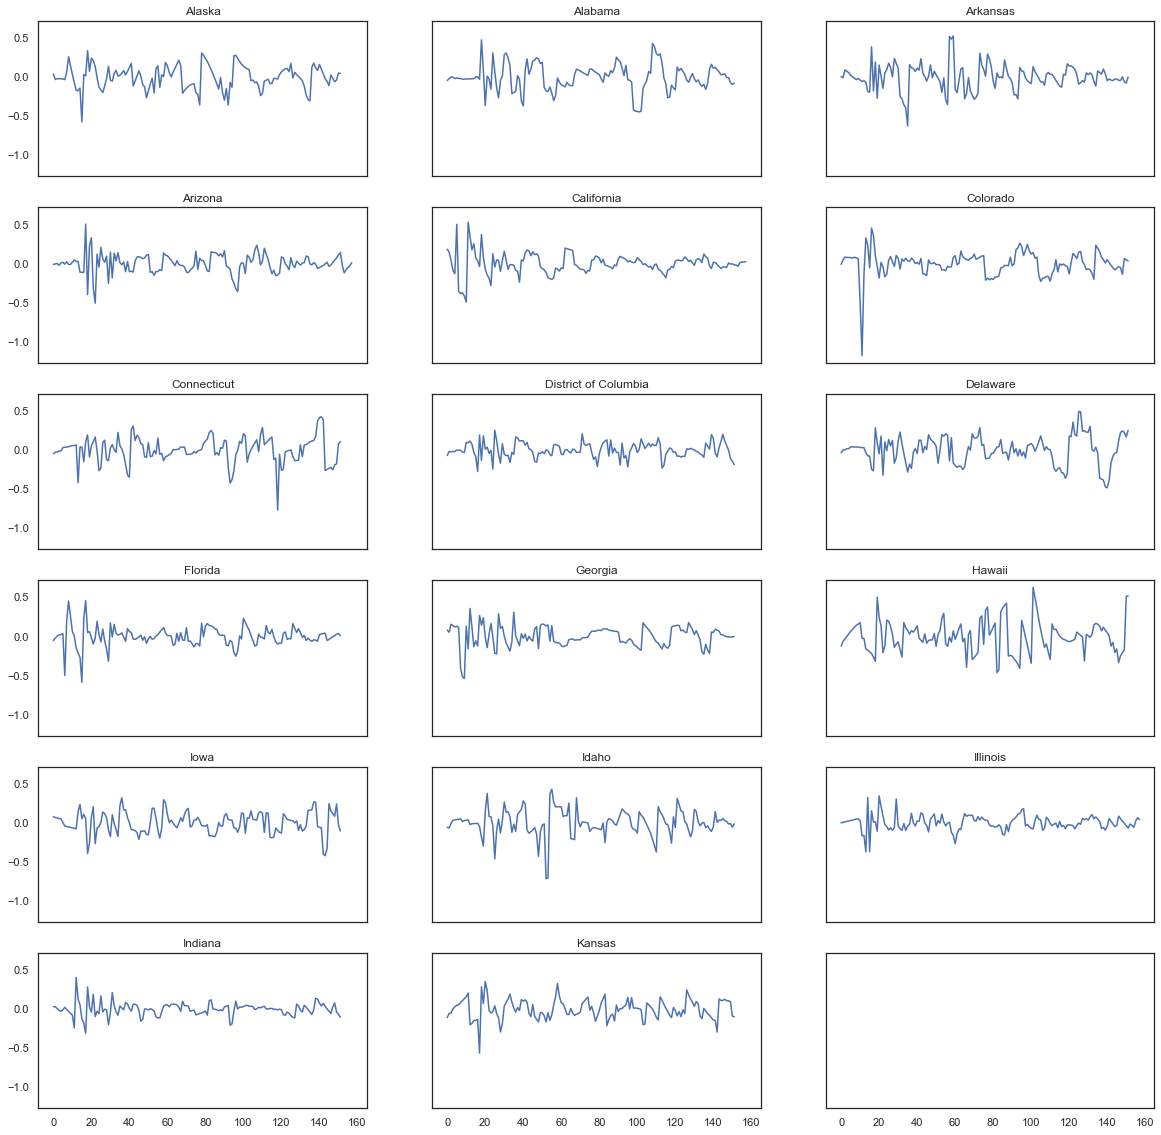

In [10]:
N = len(results_states)
fig, axs = plt.subplots(N // 3 + 1, 3, sharex=True, sharey=True, figsize=(20, 20))
for i, (s, (_, r)) in enumerate(results_states.items()):
    ax = axs[i//3, i % 3]
    ax.plot(r)
    ax.set_title(s)